In [1]:
# =========================================================
# Cell 1 : imports + reproducibility
# =========================================================
import torch, math
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(0); np.random.seed(0)

DEVICE = "cpu"          # HMC is CPU-friendly for small problems

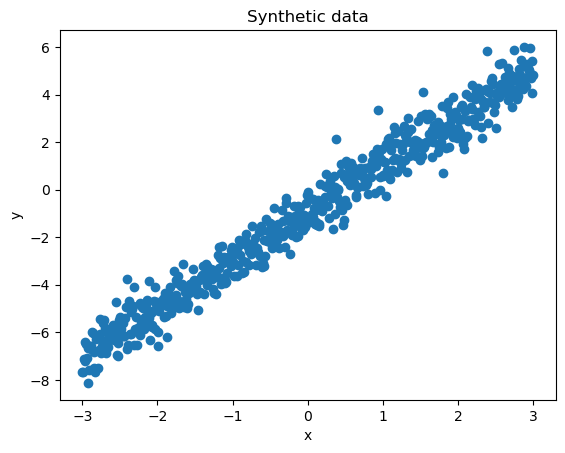

In [2]:
# =========================================================
# Cell 2 : create noisy straight-line data
# =========================================================
N          = 600
true_w     = 2.0
true_b     = -1.0
sigma_true = 0.6        # observation noise SD (unknown to the sampler)

x_data = torch.linspace(-3, 3, N)
noise  = sigma_true * torch.randn(N)
y_data = true_w * x_data + true_b + noise

plt.scatter(x_data, y_data)
plt.title("Synthetic data"); plt.xlabel("x"); plt.ylabel("y")
plt.show()

In [3]:
# =========================================================
# Cell 3 : log_posterior(θ)  where θ = (w, b, log σ)
# =========================================================
def log_posterior(theta, x, y, tau_prior=5.0):
    """
    theta = tensor([w, b, log_sigma])  (all require_grad False for MH, but
            torch.autograd.grad will need a graph when computing ∇H)
    Returns scalar log p(θ | D)  (up to constant)
    """
    w, b, log_sigma = theta
    sigma = torch.exp(log_sigma)

    # ----- log likelihood  N(y | wx + b, σ^2) -----
    ll = (-0.5 / sigma**2) * torch.sum((y - (w * x + b))**2) - y.numel() * log_sigma

    # ----- log priors  (w,b) ~ N(0, τ^2);  log σ ~ N(0,1) -----
    lp_wb   = -0.5 / tau_prior**2 * (w**2 + b**2)
    lp_logσ = -0.5 * log_sigma**2        # standard normal on log σ

    return ll + lp_wb + lp_logσ

In [4]:
# =========================================================
# Cell 4 : minimal HMC (single mass matrix = identity)
# =========================================================
def hmc(
    start,                       # initial θ  (torch tensor)
    logp_fn,                     # function returning log posterior
    step_size=0.03,
    n_leapfrog=25,
    n_samples=3_000,
    burn_in=500):
    
    samples = []
    theta   = start.clone().detach().requires_grad_(True)

    for i in range(n_samples + burn_in):
        # ----- sample momentum -----
        r = torch.randn_like(theta)

        # ----- simulate Hamiltonian dynamics -----
        theta_new = theta.clone()
        r_new     = r.clone()

        # ½ step for momentum
        logp = logp_fn(theta_new)
        grad = torch.autograd.grad(logp, theta_new)[0]
        r_new = r_new + 0.5 * step_size * grad

        # full steps
        for _ in range(n_leapfrog):
            # position step
            theta_new = theta_new + step_size * r_new
            theta_new.requires_grad_(True)

            # momentum step (except last)
            logp = logp_fn(theta_new)
            grad = torch.autograd.grad(logp, theta_new)[0]
            if _ < n_leapfrog - 1:
                r_new = r_new + step_size * grad

        # final ½ step for momentum
        r_new = r_new + 0.5 * step_size * grad
        r_new = r_new.detach()

        # ----- Metropolis accept/reject -----
        def hamiltonian(q, p):
            return -logp_fn(q) + 0.5 * torch.sum(p**2)

        current_H  = hamiltonian(theta.detach(), r)
        proposed_H = hamiltonian(theta_new.detach(), r_new)
        accept_prob = torch.exp(current_H - proposed_H).clamp(max=1.)

        if torch.rand(1) < accept_prob:
            theta = theta_new.detach().requires_grad_(True)  # accept
        # else keep old theta

        if i >= burn_in:
            samples.append(theta.detach().clone())

    return torch.stack(samples)

posterior mean  w = 2.0068039894104004
posterior mean  b = -0.9580980539321899
posterior mean σ = 0.6108154058456421


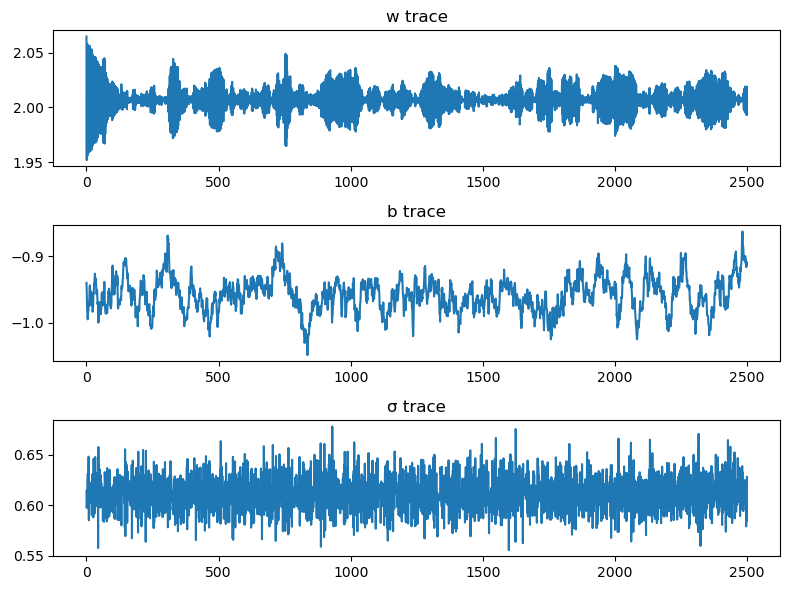

In [5]:
# =========================================================
# Cell 5 : run sampler
# =========================================================
init_theta = torch.tensor([0.0, 0.0, math.log(1.0)], requires_grad=True)

posterior = hmc(
    start      = init_theta,
    logp_fn    = lambda th: log_posterior(th, x_data, y_data),
    step_size  = 0.015,
    n_leapfrog = 20,
    n_samples  = 2_500,
    burn_in    = 500
)

w_chain   = posterior[:,0]
b_chain   = posterior[:,1]
sigma_chain = posterior[:,2].exp()

print("posterior mean  w =", w_chain.mean().item())
print("posterior mean  b =", b_chain.mean().item())
print("posterior mean σ =", sigma_chain.mean().item())

fig, ax = plt.subplots(3,1, figsize=(8,6))
ax[0].plot(w_chain);     ax[0].set_title("w trace")
ax[1].plot(b_chain);     ax[1].set_title("b trace")
ax[2].plot(sigma_chain); ax[2].set_title("σ trace")
plt.tight_layout(); plt.show()

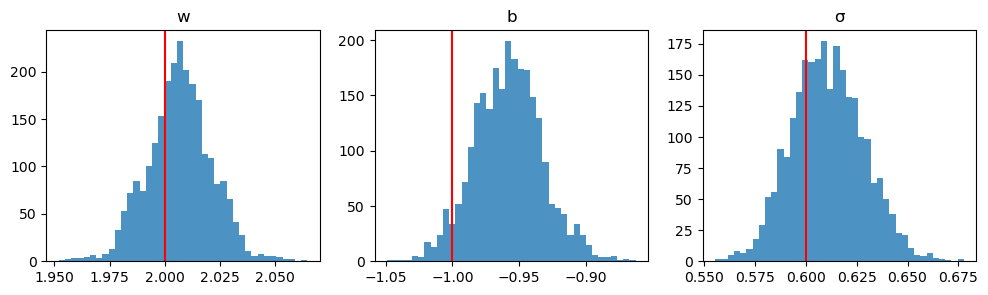

In [6]:
# =========================================================
# Cell 6 : posterior histograms vs truth
# =========================================================
fig, ax = plt.subplots(1,3, figsize=(12,3))
ax[0].hist(w_chain, bins=40, alpha=0.8); ax[0].axvline(true_w, color='r'); ax[0].set_title("w")
ax[1].hist(b_chain, bins=40, alpha=0.8); ax[1].axvline(true_b, color='r'); ax[1].set_title("b")
ax[2].hist(sigma_chain, bins=40, alpha=0.8); ax[2].axvline(sigma_true, color='r'); ax[2].set_title("σ")
plt.show()

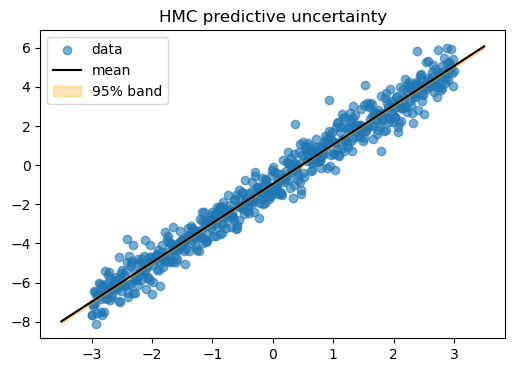

In [7]:
# =========================================================
# Cell 7 : mean prediction + 95% credible band
# =========================================================
x_plot = torch.linspace(-3.5, 3.5, 200)
# evaluate using 800 posterior samples
idx = torch.randint(len(posterior), (800,))
y_preds = []
for i in idx:
    w, b, logσ = posterior[i]
    y_preds.append(w * x_plot + b)
y_preds = torch.stack(y_preds)

mean_pred = y_preds.mean(0)
low, high = torch.quantile(y_preds, 0.025, dim=0), torch.quantile(y_preds, 0.975, dim=0)

plt.figure(figsize=(6,4))
plt.scatter(x_data, y_data, alpha=0.6, label="data")
plt.plot(x_plot, mean_pred,   color='k', label="mean")
plt.fill_between(x_plot, low, high, color='orange', alpha=0.3, label="95% band")
plt.legend(); plt.title("HMC predictive uncertainty"); plt.show()

In [8]:
# =========================================================
# Cell 8 : numeric predictions with CI on new inputs
# =========================================================
x_new = torch.linspace(-4, 4, 9)
with torch.no_grad():
    preds = []
    for th in posterior[::5]:        # fewer samples to speed up
        w, b, logσ = th
        preds.append(w * x_new + b)
    preds = torch.stack(preds)       # [samples, len(x_new)]

mean_new = preds.mean(0)
sd_new   = preds.std(0)

for xi, mu, sd in zip(x_new, mean_new, sd_new):
    print(f"x={xi:+.1f}  ŷ={mu:+.2f}  ±{1.96*sd:.2f}")

x=-4.0  ŷ=-8.98  ±0.13
x=-3.0  ŷ=-6.98  ±0.10
x=-2.0  ŷ=-4.97  ±0.08
x=-1.0  ŷ=-2.96  ±0.06
x=+0.0  ŷ=-0.96  ±0.05
x=+1.0  ŷ=+1.05  ±0.06
x=+2.0  ŷ=+3.05  ±0.08
x=+3.0  ŷ=+5.06  ±0.10
x=+4.0  ŷ=+7.07  ±0.13
